prepare data

In [ ]:
import zipfile
import os
import sys
import random
import shutil


ntst = .1
if not os.path.isdir("/kaggle/working/dataset/train/0"):
    print("unzipping")
    with zipfile.ZipFile('/kaggle/input/dogs-vs-cats/train.zip',"r") as z:
        z.extractall()    

    print("creating folders")
    os.makedirs("/kaggle/working/dataset/train/0")
    os.makedirs("/kaggle/working/dataset/train/1")
    os.makedirs("/kaggle/working/dataset/test/0")
    os.makedirs("/kaggle/working/dataset/test/1")
    os.makedirs("/kaggle/working/out")

    print("reorganizing data")
    imfn_all = os.listdir("/kaggle/working/train/")
    imfn_dogs = [imfn for imfn in imfn_all if 'dog' in imfn]
    imfn_cats = [imfn for imfn in imfn_all if 'cat' in imfn]
    random.shuffle(imfn_dogs)
    random.shuffle(imfn_cats)

    ntst_dogs = int(ntst*len(imfn_dogs))
    ntst_cats = int(ntst*len(imfn_cats))

    for i in range(len(imfn_dogs)):
        if i<ntst_dogs:
            shutil.move("/kaggle/working/train/{}".format(imfn_dogs[i]),"/kaggle/working/dataset/test/0/")
        else:
            shutil.move("/kaggle/working/train/{}".format(imfn_dogs[i]),"/kaggle/working/dataset/train/0/")

    for i in range(len(imfn_cats)):
        if i<ntst_dogs:
            shutil.move("/kaggle/working/train/{}".format(imfn_cats[i]),"/kaggle/working/dataset/test/1/")
        else:
            shutil.move("/kaggle/working/train/{}".format(imfn_cats[i]),"/kaggle/working/dataset/train/1/")

    for dirname, _, filenames in os.walk('/kaggle/working/dataset'):
        print(dirname,len(filenames))

experiments

In [29]:
import sklearn
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from sklearn import metrics
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from matplotlib.image import imread

class Const:
    def __init__(self):
        self.path_trn='/kaggle/working/dataset/train'
        self.path_tst='/kaggle/working/dataset/test'
        self.path_out='/kaggle/working/out'
        self.path_model="{}/w.h5".format(self.path_out)

        self.sz=(128, 128)
        self.is_overfitting=False
        self.is_aug=True

        self.dropout=0.25
        self.lr=.01
        self.decay_factor=.5
        self.decay_min_lr=.00001

        self.batch_sz=20,
        self.steps=100,
        self.epochs=50,
        self.bsz_infer=100
        self.val_split=.2
        self.estop_pateience=10

def viz(const):
    for c in range(2):
        print("dog" if c==0 else "cat")
        pth="{}/{}".format(const.path_trn,c)
        fn_lst=os.listdir(pth)
        random.shuffle(fn_lst)
        for i,fn in enumerate(fn_lst[:9]):
            pyplot.subplot(330 + 1 + i)
            im = imread("{}/{}/{}".format(const.path_trn , c , fn))
            pyplot.imshow(im)
        pyplot.show()

def stats(ctrn,class_weights,const):
    cls = np.unique(ctrn)
    ntotal = sum([len(os.listdir("{}/{}".format(const.path_trn, c))) for c in cls])
    ntrn = int(ntotal * (1 - const.val_split))
    nval = int(ntotal * const.val_split)
    ntst = sum([len(os.listdir("{}/{}".format(const.path_tst, c))) for c in cls])
    print("class weights", class_weights, "ntrain", ntrn, "nval", nval, \
          "ntst", ntst)
    return ntrn,nval,ntst


def get_gtrn(path, sz, bsz, validation_split, is_overfitting=False, is_aug=True):
    if is_aug:
        data_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            horizontal_flip = True,
            validation_split=validation_split,
            rescale=1./255,
            rotation_range=15,
            width_shift_range=0.1,
            height_shift_range=0.1,
            shear_range=0.1,
            zoom_range=0.2
        )
    else:
        data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split=validation_split)
    tgen = data_gen.flow_from_directory(path, target_size=sz,batch_size=20, class_mode='categorical', subset='training')
    if is_overfitting:
        vgen=tgen
    else:
        vgen = data_gen.flow_from_directory(path, target_size=sz,batch_size=20, class_mode='categorical',subset='validation')
    return tgen, vgen


def get_gtst(path, sz,bsz):
    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    gen = data_gen.flow_from_directory(path, target_size=sz,batch_size=20, class_mode='categorical')
    return gen


def load_model(sz,const):
    input = tf.keras.Input(shape=(sz[0], sz[1], 3))

    out=tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=32, activation="relu")(input)
    out=tf.keras.layers.BatchNormalization()(out)
    out=tf.keras.layers.MaxPooling2D()(out)
#    out=tf.keras.layers.Dropout(const.dropout)(out)

    out=tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=64, activation="relu")(out)
    out=tf.keras.layers.BatchNormalization()(out)
    out=tf.keras.layers.MaxPooling2D()(out)
#    out=tf.keras.layers.Dropout(const.dropout)(out)

    out=tf.keras.layers.Conv2D(kernel_size=(3, 3), filters=128, activation="relu")(out)
    out=tf.keras.layers.BatchNormalization()(out)
    out=tf.keras.layers.MaxPooling2D()(out)
#    out=tf.keras.layers.Dropout(const.dropout)(out)

    out=tf.keras.layers.Flatten()(out)
    out=tf.keras.layers.Dense(512, activation='relu')(out)
    out=tf.keras.layers.BatchNormalization()(out)
#    out=tf.keras.layers.Dropout(const.dropout)(out)
    out=tf.keras.layers.Dense(2, activation='softmax')(out)

    model=tf.keras.models.Model(inputs=input, outputs=out)
    loss = tf.keras.losses.CategoricalCrossentropy()
    opt = tf.keras.optimizers.RMSprop(learning_rate=const.lr)
    model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

    model.summary()
    return model


def train(const,expr_name=""):
#    tf.debugging.set_log_device_placement(True)

    print("\nloading model",flush=True)
    model = load_model(const.sz,const)

    # prepare and balance data loaders
    print("\nloading training data",flush=True)
    gtrn, gval = get_gtrn(const.path_trn,const.sz, const.batch_sz, validation_split=const.val_split, \
                               is_overfitting=const.is_overfitting, is_aug=const.is_aug)
    ctrn = gtrn.classes
    class_weights = sklearn.utils.compute_class_weight(class_weight='balanced', classes=np.unique(ctrn), y=ctrn)
    class_weights = dict(zip(np.unique(ctrn), class_weights))

    # data stats
    print("data:",end=" ",flush=True)
    print(const.path_trn)
    stats(ctrn,class_weights,const)

    # train
    print("\ntraining",flush=True)
    ncpu = os. cpu_count()
    print("ncpu",ncpu)
    estop=tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=const.estop_pateience, \
                                           verbose=2, mode="min", restore_best_weights=True)
    decay = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, \
                                                 factor=const.decay_factor, min_lr=const.decay_min_lr)
    checkpoint = tf.keras.callbacks.ModelCheckpoint("{}/w_{}.h5".format(c.path_out, expr_name), \
                                                    monitor='loss', verbose=1, save_best_only=True, mode='min')

    history = model.fit(gtrn, validation_data=gval, epochs=const.epochs, \
                        class_weight=class_weights, callbacks=[estop, decay,checkpoint],
                        use_multiprocessing=True,workers=ncpu)
    model.save_weights(const.path_model)
    
    # training history visualization
    print("visualizing training process",flush=True)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('acc')
    plt.ylabel('acc')
    plt.xlabel('epoch')
    plt.legend(['trn', 'val'], loc='upper left')
    #plt.savefig("{}/acc.jpg".format(const.path_out))
    plt.show()
    plt.close()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('e')
    plt.legend(['trn', 'val'], loc='upper left')
    #plt.savefig("{}/loss.jpg".format(const.path_out))
    plt.show()
    plt.close()

    
def eval(const):
    model=load_model(const.sz,const)
    model.load_weights(const.path_model)
    gtst=get_gtst(const.path_tst if not const.is_overfitting else const.path_trn,const.sz,const.batch_sz)
    test_scores = model.evaluate(x=gtst, verbose=2)
    print("loss",test_scores[0],"acc",test_scores[1])

def test(const):
    model = load_model(const.sz,const)
    model.load_weights(const.path_model)

    data_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    gen = data_gen.flow_from_directory(
        const.path_tst if not const.is_overfitting else const.path_trn, 
        target_size=(128,128),
        batch_size=1, 
        class_mode='categorical', 
        shuffle=False)
    
    P = model.predict(gen,verbose=1)
    
    print("dogs")
    fpr, rec, _ = roc_curve(gen.classes, P[:,0],pos_label=0)
    plt.plot(fpr,rec)
    plt.ylabel('rec')
    plt.xlabel('fpr')
    plt.show()
    plt.close()
    
    print("cats")
    fpr, rec, _ = roc_curve(gen.classes, P[:,1],pos_label=1)
    plt.plot(fpr,rec)
    plt.ylabel('rec')
    plt.xlabel('fpr')
    plt.show()
    plt.close()
    
    print("\nperformance statistics:")
    for c in range(2):
        rec,fpr=[],[]
        for th in [.98,.95]+[1./(th+1) for th in range(1,10)]+[.05,.02,0]:
            data={'tp':0, 'fp':0, 'tn':0, 'fn':0}
            for i in range(P.shape[0]):
                if gen.classes[i]==c:
                    if P[i, c]>=th:
                        data['tp']+=1
                    else:
                        data['fn']+=1
                else:
                    if P[i, c]>=th:
                        data['fp']+=1
                    else:
                        data['tn']+=1
            pos = data['tp'] + data['fn']
            neg = data['tn'] + data['fp']

            rec += [float(data['tp'])/pos]
            fpr += [float(data['fp'])/neg]
            print("class {} th {:.2f} rec {:.3f} fpr {:.3f} pos {} neg {} tp {} fp {} tn {} fn {}".format(c,th,rec[-1],fpr[-1],pos,neg,data['tp'],data['fp'],data['tn'],data['fn']))
        print("\n")

experiments

e50_drop0_bn1_aug1_overfit1_ntrnALL
dog


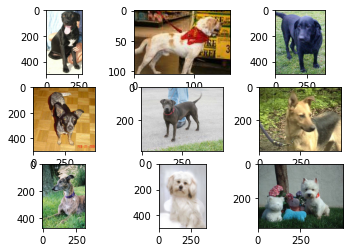

cat


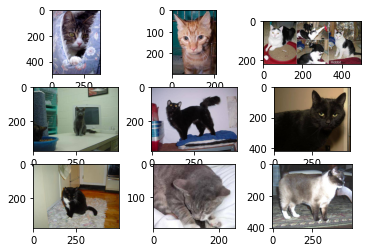


loading model
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_32 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_33 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 30, 30, 

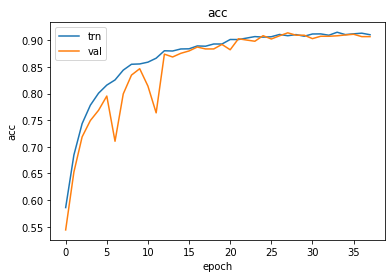

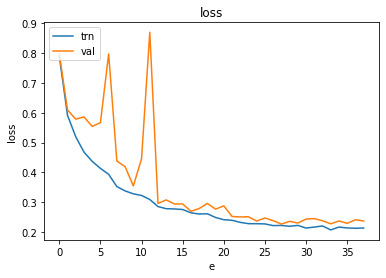

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_36 (Batc (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_37 (Batc (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 30, 30, 64)        0   

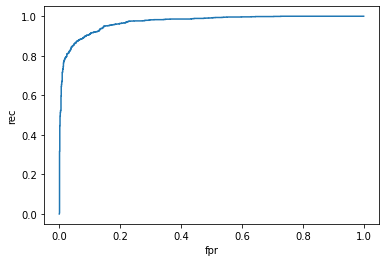

cats


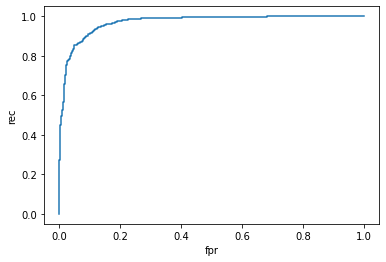


performance statistics:
class 0 th 0.98 rec 0.611 fpr 0.006 pos 1274 neg 1250 tp 779 fp 8 tn 1242 fn 495
class 0 th 0.95 rec 0.717 fpr 0.010 pos 1274 neg 1250 tp 914 fp 13 tn 1237 fn 360
class 0 th 0.50 rec 0.912 fpr 0.103 pos 1274 neg 1250 tp 1162 fp 129 tn 1121 fn 112
class 0 th 0.33 rec 0.938 fpr 0.138 pos 1274 neg 1250 tp 1195 fp 172 tn 1078 fn 79
class 0 th 0.25 rec 0.952 fpr 0.160 pos 1274 neg 1250 tp 1213 fp 200 tn 1050 fn 61
class 0 th 0.20 rec 0.959 fpr 0.183 pos 1274 neg 1250 tp 1222 fp 229 tn 1021 fn 52
class 0 th 0.17 rec 0.963 fpr 0.199 pos 1274 neg 1250 tp 1227 fp 249 tn 1001 fn 47
class 0 th 0.14 rec 0.968 fpr 0.217 pos 1274 neg 1250 tp 1233 fp 271 tn 979 fn 41
class 0 th 0.12 rec 0.973 fpr 0.226 pos 1274 neg 1250 tp 1240 fp 282 tn 968 fn 34
class 0 th 0.11 rec 0.976 fpr 0.238 pos 1274 neg 1250 tp 1243 fp 298 tn 952 fn 31
class 0 th 0.10 rec 0.976 fpr 0.254 pos 1274 neg 1250 tp 1244 fp 317 tn 933 fn 30
class 0 th 0.05 rec 0.983 fpr 0.323 pos 1274 neg 1250 tp 1252 fp 404

In [30]:
if __name__=='__main__':
    """
    start: subset , im size 32x32 , overfit (im size 32x32) , rmsprop
    res: trn loss plateaue
    """
    expr_name = "e10_sz32_drop0_bn0_aug0_overfit1_ntrn1K"
    c = Const()
    c.path_trn = "/kaggle/working/dataset/train1000"
    c.epochs = 10
    c.dropout = 0
    c.is_overfitting = True
    c.is_aug = False
    c.sz = (32, 32)
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    #print(expr_name)
    #train(c)
    #eval(c)

    """
    changes: all data
    res: trn loss plateaue
    """
    expr_name = "e50_sz32_drop0_bn0_aug0_overfit1_ntrnALL"
    c = Const()
    c.path_trn = "/kaggle/working/dataset/train"
    c.epochs = 50
    c.dropout = 0
    c.is_overfitting = True
    c.is_aug = False
    c.sz = (32, 32)
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    #print(expr_name)
    #train(c)
    #eval(c)
    
    """
    changes: im size 128x128 , non overfit , aug
    res: trn loss plateaue
    """
    expr_name = "e100_drop0_bn1_aug1_overfit0_ntrnALL"
    c = Const()
    c.path_train = "/kaggle/working/dataset/train"
    c.epochs = 100
    c.dropout = 0
    c.is_overfitting = False
    c.is_aug = True
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    #print(expr_name)
    #train(c)
    #eval(c)
    
    """
    changes: overfit , dropout p=.25
    res: trn loss plateaue
    """
    expr_name = "e50_sz128_drop25_bn0_aug1_overfit1_ntrnALL"
    c = Const()
    c.path_train = "/kaggle/working/dataset/train"
    c.epochs = 50
    c.dropout = .25
    c.is_overfitting = True
    c.is_aug = True
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    #print(expr_name)
    #train(c)
    #eval(c)
    
    """
    prev: e100_drop0_bn1_aug1_overfit0_ntrnALL
    changes: overfit , bn
    res: trn & val losses converges in 15e
    """
    expr_name = "e50_sz128_drop0_bn1_aug1_overfit1_ntrnALL"
    c = Const()
    c.path_train = "/kaggle/working/dataset/train"
    c.epochs = 50
    c.dropout = 0
    c.is_overfitting = True
    c.is_aug = True
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    #print(expr_name)
    #train(c)
    #eval(c)
    
    """
    changes: eval test
    """
    expr_name = "e50_drop0_bn1_aug1_overfit1_ntrnALL"
    c = Const()
    c.path_train = "/kaggle/working/dataset/train"
    c.epochs = 50
    c.dropout = 0
    c.is_overfitting = False
    c.is_aug = True
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    #print(expr_name)
    #train(c,expr_name)
    #eval(c)
    
    """
    changes: +roc
    """
    expr_name = "e50_drop0_bn1_aug1_overfit1_ntrnALL"
    c = Const()
    c.path_train = "/kaggle/working/dataset/train"
    c.path_train = "/kaggle/working/dataset/test"
    c.epochs = 50
    c.dropout = 0
    c.is_overfitting = False
    c.is_aug = True
    c.path_model = "{}/w_{}.h5".format(c.path_out, expr_name)
    print(expr_name)
    viz(c)
    train(c,expr_name)
    eval(c)
    test(c)